In [17]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from tqdm.notebook import tqdm
from absl import flags

## Relative imports
from dataHandler.dataset import MHDProjDataset,LogNormalTransform

from ddpm.model import UNet, ResUNet
from ddpm.diffusion import DDPM, generate_image, NCSN

from validationMetrics.powerSpectrum import power_spectrum_iso, plot_ps, compare_separation_power_spectrum_iso
from validationMetrics.minkowskiFunctional import plot_mink_functionals

from separation import double_loader, method1_algo2, check_separation1score, separation1score

from scipy.signal import savgol_filter

import bm3d
from bm3d import bm3d, BM3DProfile, BM3DStages

In [18]:
MODEL_ID1 = 'MHDsame_SigmaDDPM_skip_GN_bottleneck32_diffusion1000_wd1e-4_csize6'

CKPT_FOLDER1 = '/mnt/home/dheurtel/ceph/10_checkpoints/artificial_architecture_exps'

MODEL_ID2 = 'GRF2_DDPM_skip_GN_bottleneck32_diffusion2000'

CKPT_FOLDER2 = '/mnt/home/dheurtel/ceph/10_checkpoints/artificial_architecture_exps'

NUM_SAMPLES = 32

In [19]:
amin,amax=(-6.232629, 7.390278)
bins = np.linspace(0, np.pi, 100)

In [20]:
model1, model2, testbatch1, testbatch2 = double_loader(MODEL_ID1, CKPT_FOLDER1, MODEL_ID2, CKPT_FOLDER2)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## One score source separation/denoising with gaussian fields (from standard gaussian to CMB gaussian random field)

In [22]:
def rescale_preserved_to_additive(model, noisy_x, timesteps):
    """"Rescale add noise of the ddpm to have additive variance not preserved variance"""
    s1 = model.sqrt_alphas_cumprod[timesteps] 
    s1 = s1.reshape(-1,1,1,1)
    return  noisy_x/s1

def rescale_additive_to_preserved(model, noisy_x, timesteps):
    """"Rescale add noise of the ddpm to have additive variance not preserved variance"""
    s1 = model.sqrt_alphas_cumprod[timesteps] 
    s1 = s1.reshape(-1,1,1,1)
    return  noisy_x*s1

In [23]:
t = 200
noise_strength = (model1.sqrt_one_minus_alphas_cumprod[t]/model1.sqrt_alphas_cumprod[t]).cpu().detach().item()

In [24]:
noise_strength

0.7235910892486572

In [25]:
truth_list, noisy_list, denoised_list = check_separation1score(MODEL_ID1, CKPT_FOLDER1, t, 1, 32, False)

100%|██████████| 200/200 [00:04<00:00, 49.72it/s]


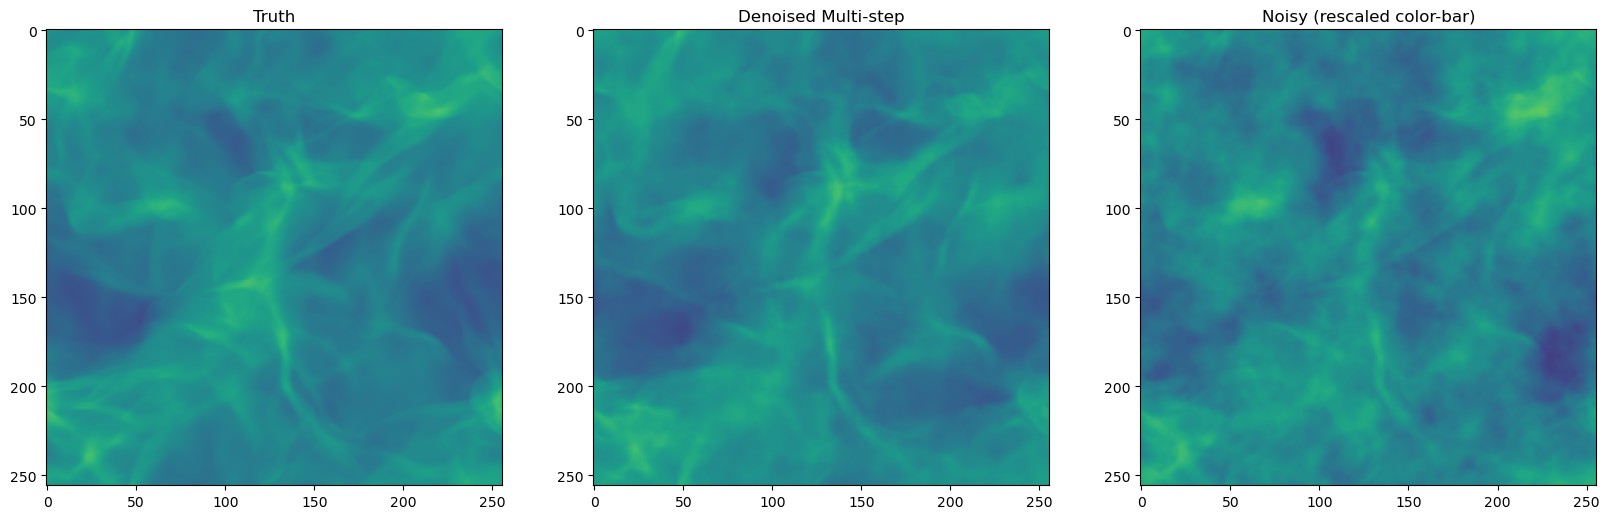

In [26]:
fig, ax= plt.subplots(1,3,figsize=(20,8))
ax[0].imshow(truth_list[0][0][0],vmin=amin, vmax=amax)
ax[0].title.set_text('Truth')
ax[1].imshow(denoised_list[0][0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[1].title.set_text('Denoised Multi-step')
ax[2].imshow(noisy_list[0][0][0].detach().cpu(),vmin=np.sqrt(1+ noise_strength)*amin, vmax=np.sqrt(1+noise_strength)*amax)
ax[2].title.set_text('Noisy (rescaled color-bar)')

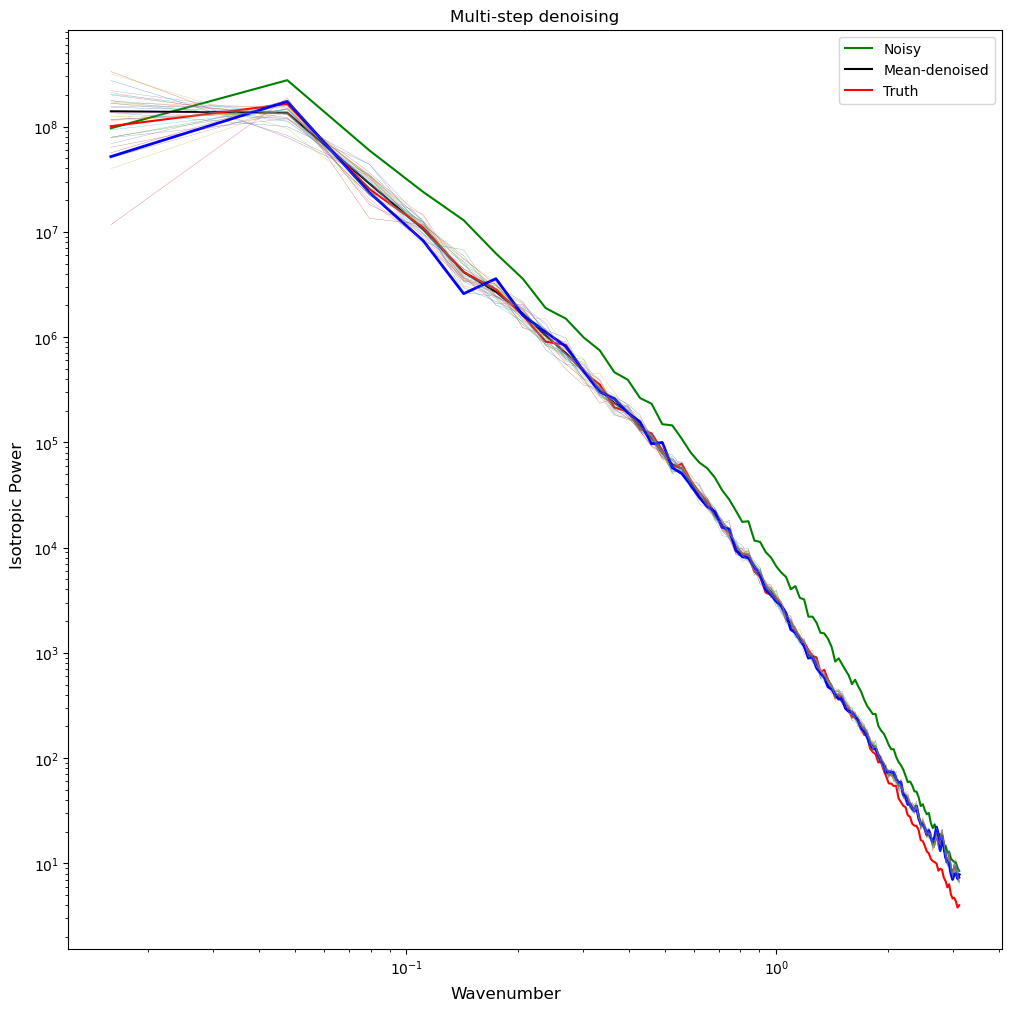

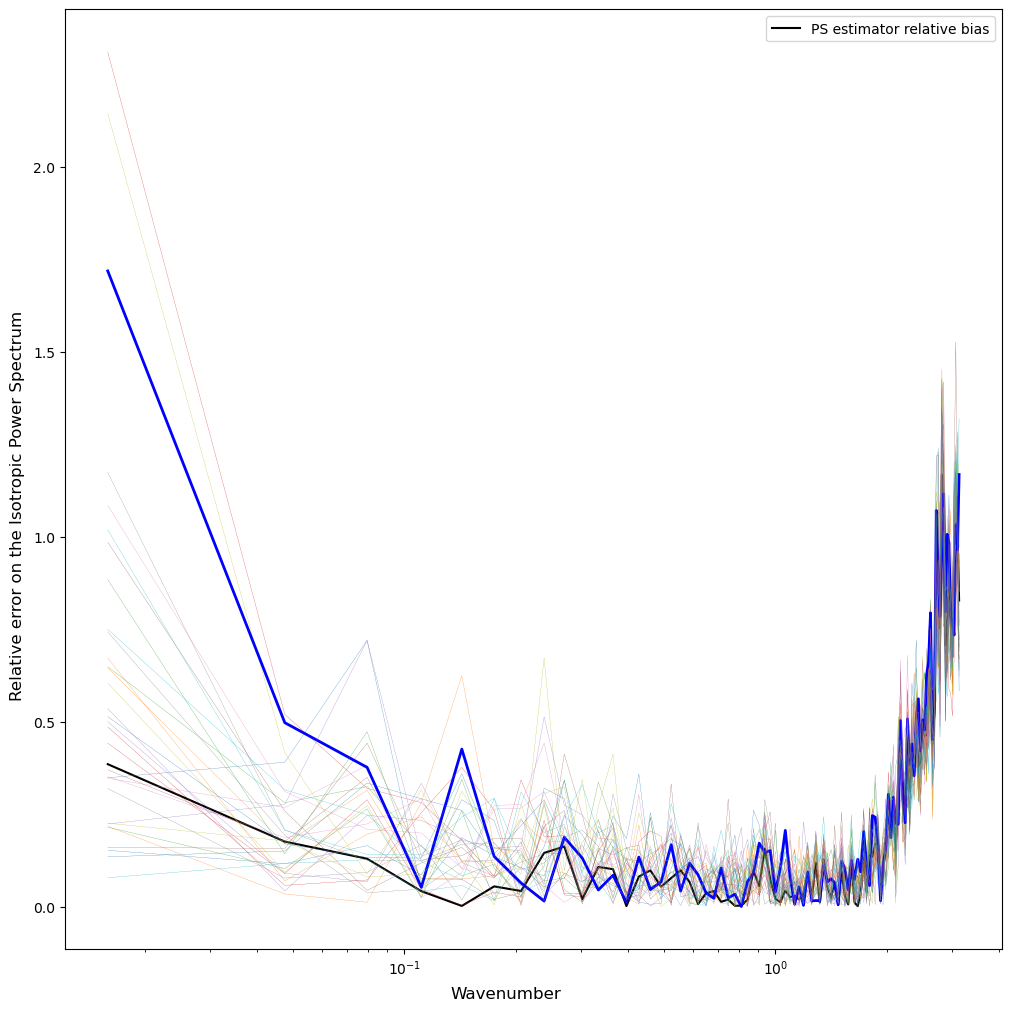

In [27]:
b0, b3, mean_, std_, bins = compare_separation_power_spectrum_iso(truth_list[0],denoised_list[0], noisy = noisy_list[0], only_trajectories= True, title= 'Multi-step denoising', relative_error= True)

Check tweedie (one step denoising)

In [28]:
truth_list, noisy_list, denoised_list = check_separation1score(MODEL_ID1, CKPT_FOLDER1, t, 1, 32, True)

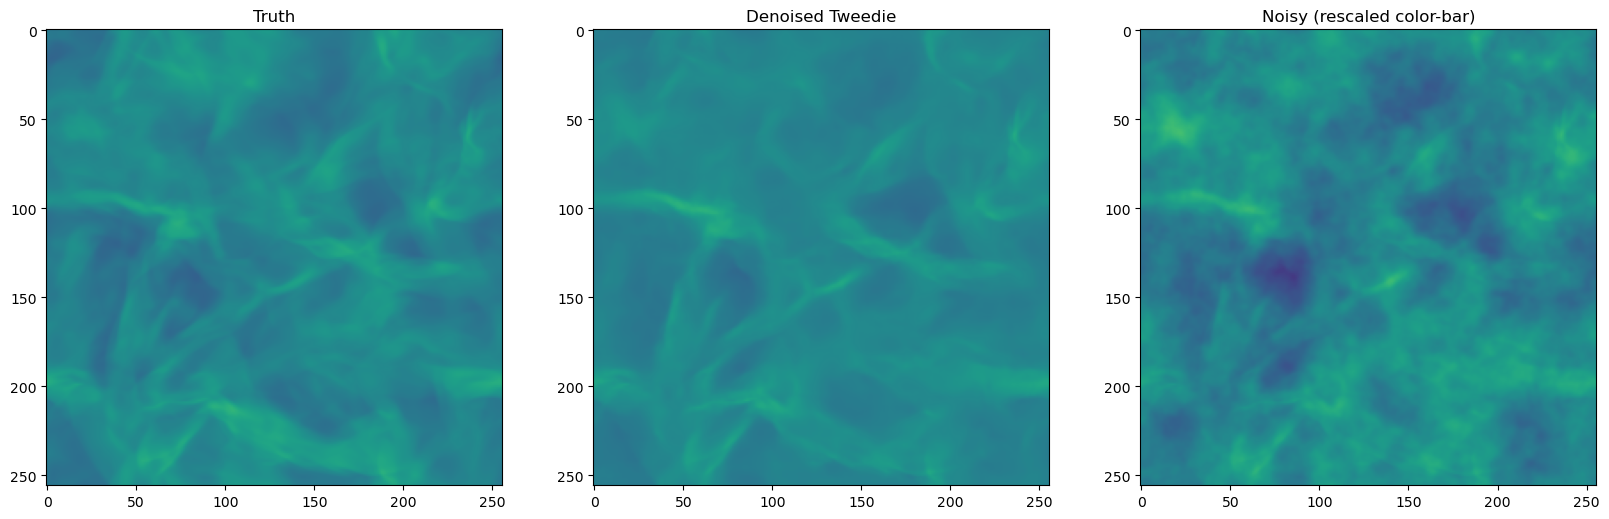

In [29]:
fig, ax= plt.subplots(1,3,figsize=(20,8))
ax[0].imshow(truth_list[0][0][0],vmin=amin, vmax=amax)
ax[0].title.set_text('Truth')
ax[1].imshow(denoised_list[0][0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[1].title.set_text('Denoised Tweedie')
ax[2].imshow(noisy_list[0][0][0].detach().cpu(),vmin=np.sqrt(1+ noise_strength)*amin, vmax=np.sqrt(1+noise_strength)*amax)
ax[2].title.set_text('Noisy (rescaled color-bar)')

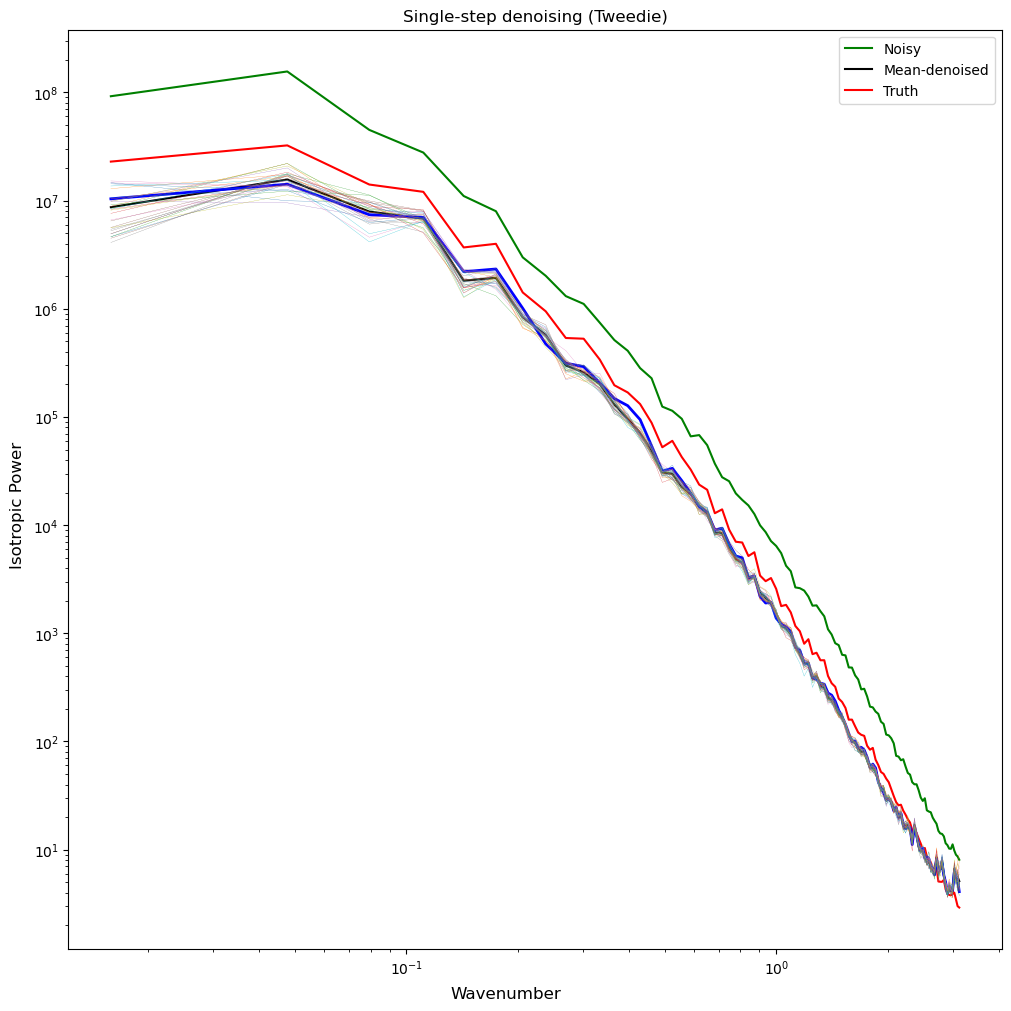

In [30]:
b0, b3, mean_, std_, bins = compare_separation_power_spectrum_iso(truth_list[0],denoised_list[0], noisy = noisy_list[0], only_trajectories= True, title = 'Single-step denoising (Tweedie)')

### BM3D

In [31]:
num_to_denoise = 1
noise_step = 200
NUM_SAMPLES = 128

In [32]:
truth = testbatch1[:num_to_denoise].to(device)

In [33]:
noise=torch.randn_like(truth)
timesteps=torch.full((truth.shape[0],), noise_step).long().to(device)

noise_strength = model1.sqrt_one_minus_alphas_cumprod[noise_step]/model1.sqrt_alphas_cumprod[noise_step]
noise_strength = noise_strength.detach().cpu().item()
noise_strength

0.7235910892486572

In [34]:
observation , _ = model1.add_noise(truth,noise, timesteps)
#observation = model1.sqrt_alphas_cumprod[noise_step]*truth + model1.sqrt_one_minus_alphas_cumprod[noise_step]*noise
observation = rescale_preserved_to_additive(model1, observation, noise_step)

In [35]:
EXPLORE = '/mnt/home/dheurtel/ceph/00_exploration_data/power_spectra/'

In [36]:
power_spectrum = torch.from_numpy(np.load(os.path.join(EXPLORE, 'same.npy')))

In [53]:
denoised_bm3d = bm3d(observation[0][0].cpu().detach().numpy(), profile = 'refilter', sigma_psd = noise_strength * 65536 * power_spectrum, stage_arg=BM3DStages.HARD_THRESHOLDING, )#stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING

In [54]:
help(bm3d)

Help on function bm3d in module bm3d:

bm3d(z: numpy.ndarray, sigma_psd: Union[numpy.ndarray, list, float], profile: Union[bm3d.profiles.BM3DProfile, str] = 'np', stage_arg: Union[bm3d.profiles.BM3DStages, numpy.ndarray] = <BM3DStages.ALL_STAGES: 3>, blockmatches: tuple = (False, False)) -> Union[numpy.ndarray, Tuple[numpy.ndarray, Tuple[numpy.ndarray, numpy.ndarray]]]
    Perform BM3D denoising on z: either hard-thresholding, Wiener filtering or both.
    
    :param z: Noisy image. either MxN or MxNxC where C is the channel count.
              For multichannel images, blockmatching is performed on the first channel.
    :param sigma_psd: Noise PSD, either MxN or MxNxC (different PSDs for different channels)
            or
           sigma_psd: Noise standard deviation, either float, or length C list of floats
    :param profile: Settings for BM3D: BM3DProfile object or a string
                    ('np', 'refilter', 'vn', 'vn_old', 'high', 'deb'). Default 'np'.
    :param stage_arg:

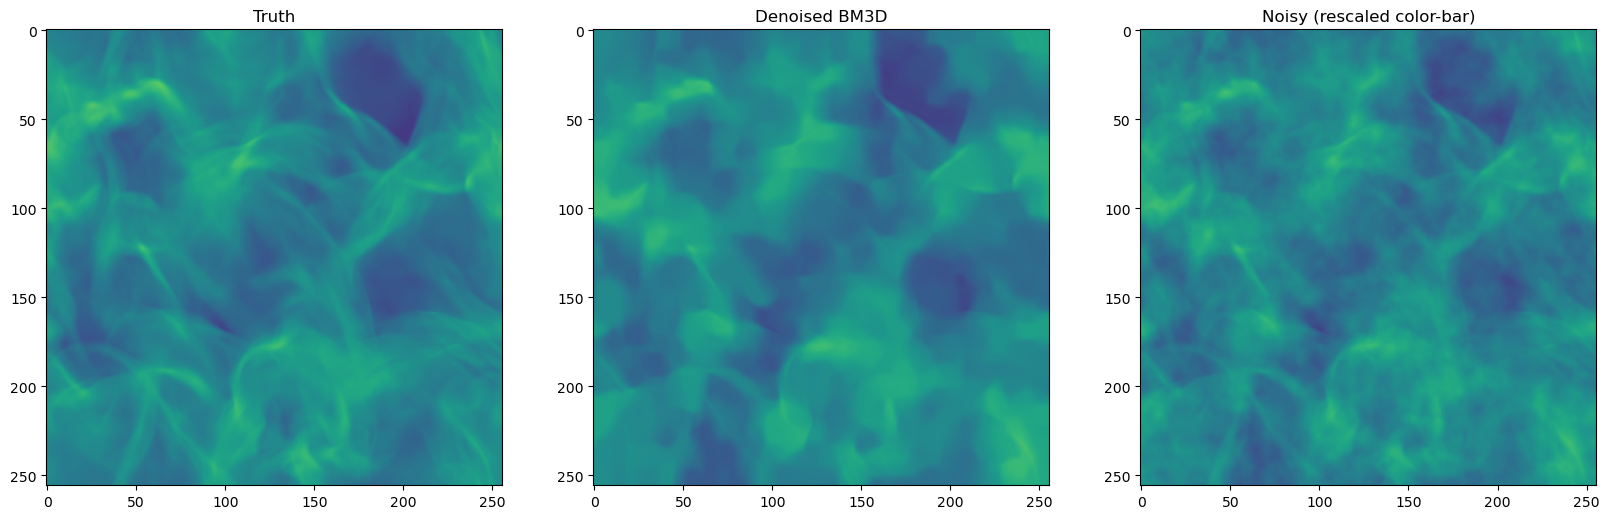

In [55]:
## Plot the truth, the bm3d_denoised image and the observation
fig, ax= plt.subplots(1,3,figsize=(20,8))
ax[0].imshow(truth[0][0].cpu().detach().numpy(),vmin=amin, vmax=amax)
ax[0].title.set_text('Truth')
ax[1].imshow(denoised_bm3d,vmin=amin, vmax=amax)
ax[1].title.set_text('Denoised BM3D')
ax[2].imshow(observation[0][0].cpu().detach().numpy(),vmin=np.sqrt(1+ noise_strength)*amin, vmax=np.sqrt(1+noise_strength)*amax)
ax[2].title.set_text('Noisy (rescaled color-bar)')

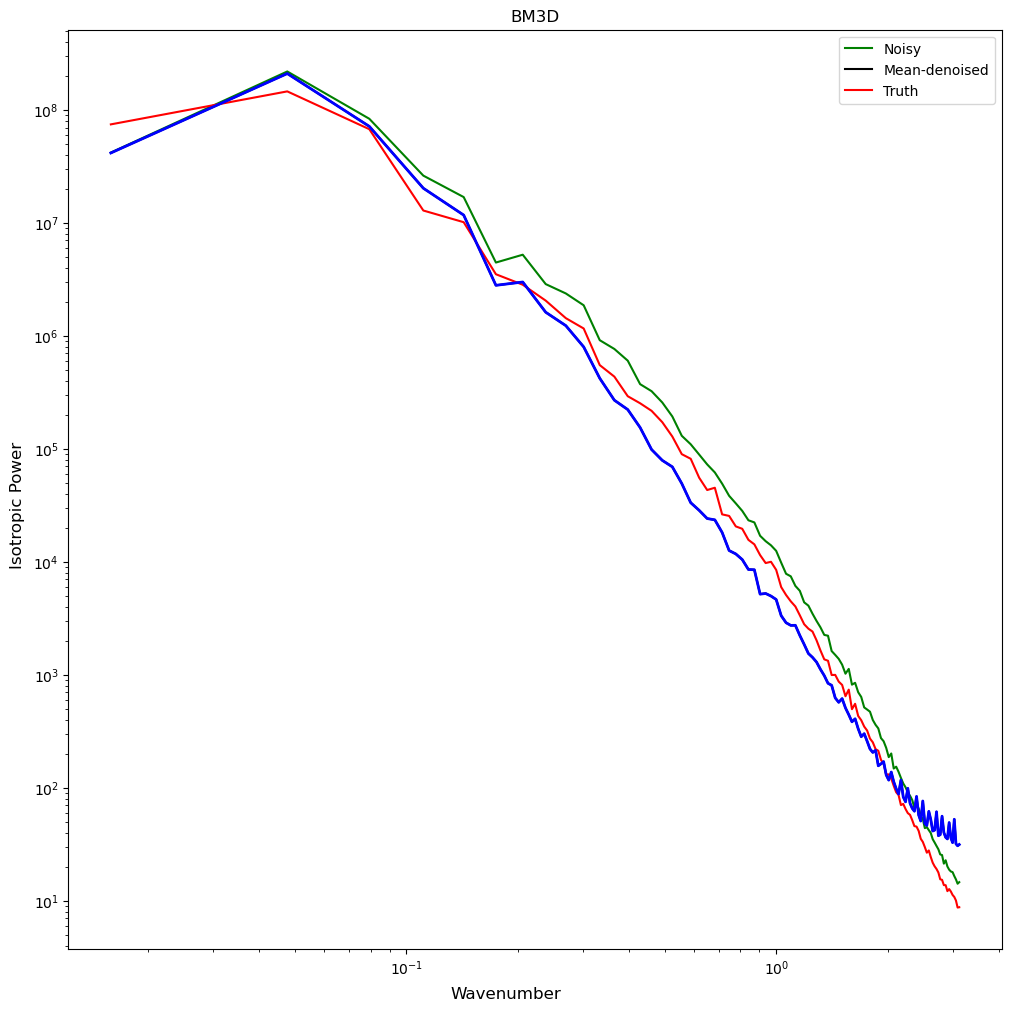

In [56]:
b0, b3, mean_, std_, bins = compare_separation_power_spectrum_iso(truth,torch.from_numpy(denoised_bm3d.reshape(1,1,256,256)), noisy = observation, only_trajectories= True, title = 'BM3D')

### Verify that MMSE estimator is mean of the conditional distribution after denoising

In [72]:
noisy_list, denoised_list = separation1score(MODEL_ID1, CKPT_FOLDER1, observation, noise_step=noise_step, NUM_SAMPLES=NUM_SAMPLES, tweedie=False, rescale_observation=True)

100%|██████████| 500/500 [00:37<00:00, 13.29it/s]


In [73]:
noisy_list2, denoised_list2 = separation1score(MODEL_ID1, CKPT_FOLDER1, observation, noise_step=noise_step, NUM_SAMPLES=1, tweedie=True, rescale_observation=True)

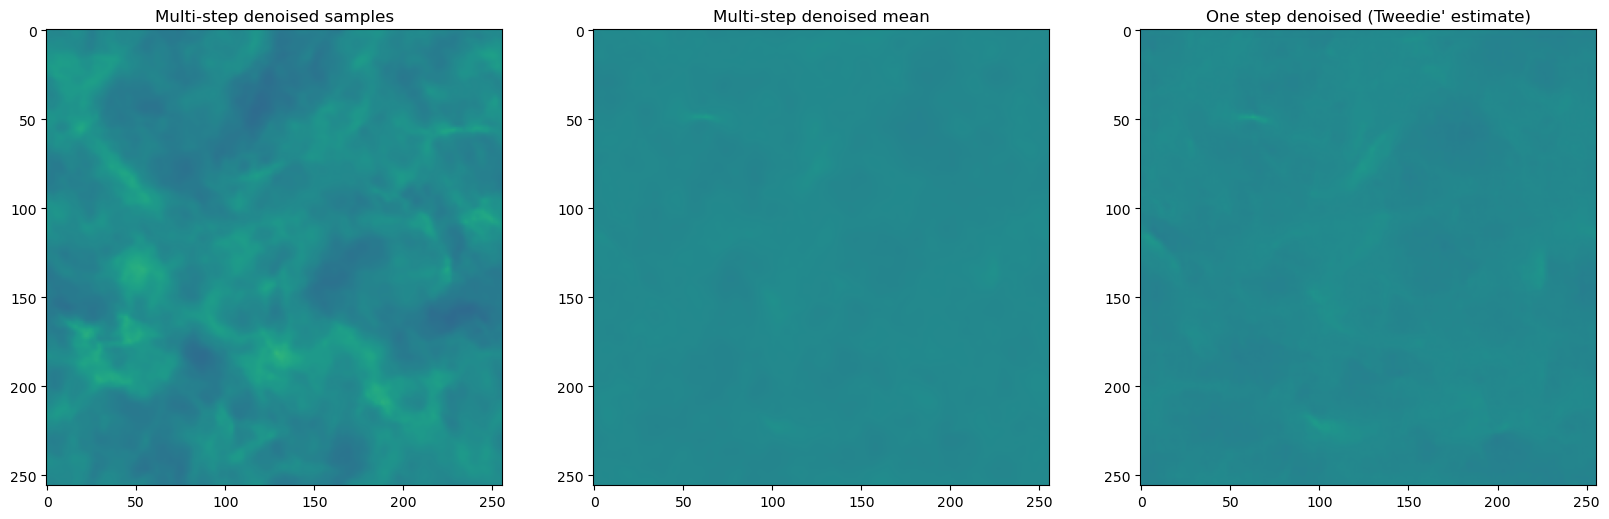

In [74]:
### MODIFIED COLOR BAR TO SEE MORE DETAILS
fig, ax= plt.subplots(1,3,figsize=(20,8))
ax[0].imshow(denoised_list[0][0][0].detach().cpu(),vmin=amin*0.9, vmax=amax*0.9)
ax[0].title.set_text('Multi-step denoised samples')
ax[1].imshow(denoised_list[0].mean(dim=0)[0].detach().cpu(),vmin=amin*0.9, vmax=amax*0.9)
ax[1].title.set_text('Multi-step denoised mean')
ax[2].imshow(denoised_list2[0][0][0].detach().cpu(),vmin=amin*0.9, vmax=amax*0.9)
ax[2].title.set_text("One step denoised (Tweedie' estimate)")

In [75]:
print("L2 distance (squared) between Tweedie's estimate and average of multistep denoising : "+str(F.mse_loss(denoised_list2[0][0][0], denoised_list[0].mean(dim=0)[0]).detach().cpu().item()))
print("MSE between the multistep denoising distribution and Tweedie's estimate : "+str(F.mse_loss(denoised_list2[0][:1].repeat(NUM_SAMPLES,1 ,1, 1), denoised_list[0][:]).detach().cpu().item()))

L2 distance (squared) between Tweedie's estimate and average of multistep denoising : 0.015823939815163612
MSE between the multistep denoising distribution and Tweedie's estimate : 0.29302719235420227


#### PSNR Computation

In [76]:
NUM_SAMPLES = 16

In [77]:
times = range(0, model1.num_timesteps, 100)
noise_level = (model1.sqrt_one_minus_alphas_cumprod / model1.sqrt_alphas_cumprod)[times]

max2_I = truth.square().max()

noisy_psnr_list = []
denoised_psnr_list = []
denoised_tweedies_psnr_list = []

noisy_snr_list = []
denoised_snr_list = []
denoised_tweedies_snr_list = []

for t in times:
    noise=torch.randn_like(truth)
    timesteps=torch.full((truth.shape[0],), t).long().to(device)

    observation , _ = model1.add_noise(truth,noise, t)
    observation = rescale_preserved_to_additive(model1, observation, t)

    _ , denoised_list = separation1score(MODEL_ID1, CKPT_FOLDER1, observation, noise_step=t, NUM_SAMPLES=NUM_SAMPLES, tweedie=False, rescale_observation=True)
    _ , denoised_list2 = separation1score(MODEL_ID1, CKPT_FOLDER1, observation, noise_step=t, NUM_SAMPLES=1, tweedie=True, rescale_observation=True)
    
    PSNR_noisy = 10 * torch.log10(max2_I/F.mse_loss(observation,truth))
    PSNR_denoised = 10 * torch.log10(max2_I/F.mse_loss(denoised_list[0],truth.repeat(NUM_SAMPLES, 1, 1, 1)))
    PSNR_tweedie = 10 * torch.log10(max2_I/F.mse_loss(denoised_list2[0], truth))

    noisy_psnr_list.append(PSNR_noisy.detach().cpu().item())
    denoised_psnr_list.append(PSNR_denoised.detach().cpu().item())
    denoised_tweedies_psnr_list.append(PSNR_tweedie.detach().cpu().item())
    

0it [00:00, ?it/s]
 93%|█████████▎| 279/300 [00:03<00:00, 86.97it/s]

KeyboardInterrupt: 

 94%|█████████▎| 281/300 [00:15<00:00, 86.97it/s]

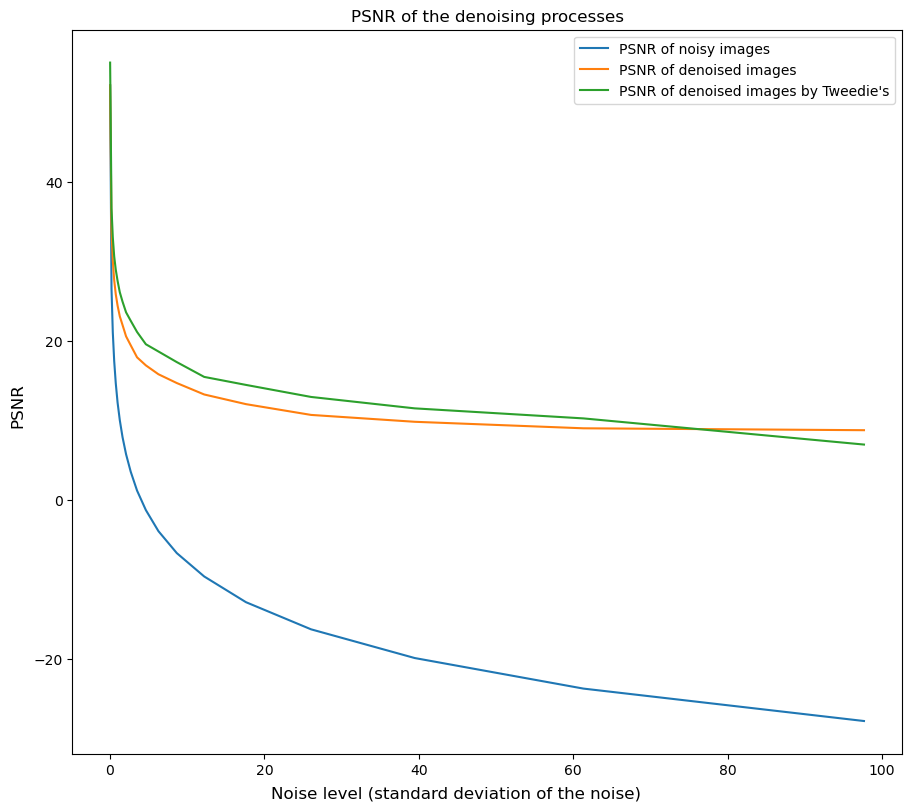

In [ ]:
fig, ax= plt.subplots(1,1,figsize=(9,8), layout = 'constrained')
ax.plot(noise_level.detach().cpu(), noisy_psnr_list, label = 'PSNR of noisy images')
ax.plot(noise_level.detach().cpu(), denoised_psnr_list, label = 'PSNR of denoised images')
ax.plot(noise_level.detach().cpu(), denoised_tweedies_psnr_list, label = "PSNR of denoised images by Tweedie's")
ax.legend()
fig.supylabel('PSNR')
fig.supxlabel('Noise level (standard deviation of the noise)')
ax.title.set_text('PSNR of the denoising processes')

NameError: name 'noise_level' is not defined

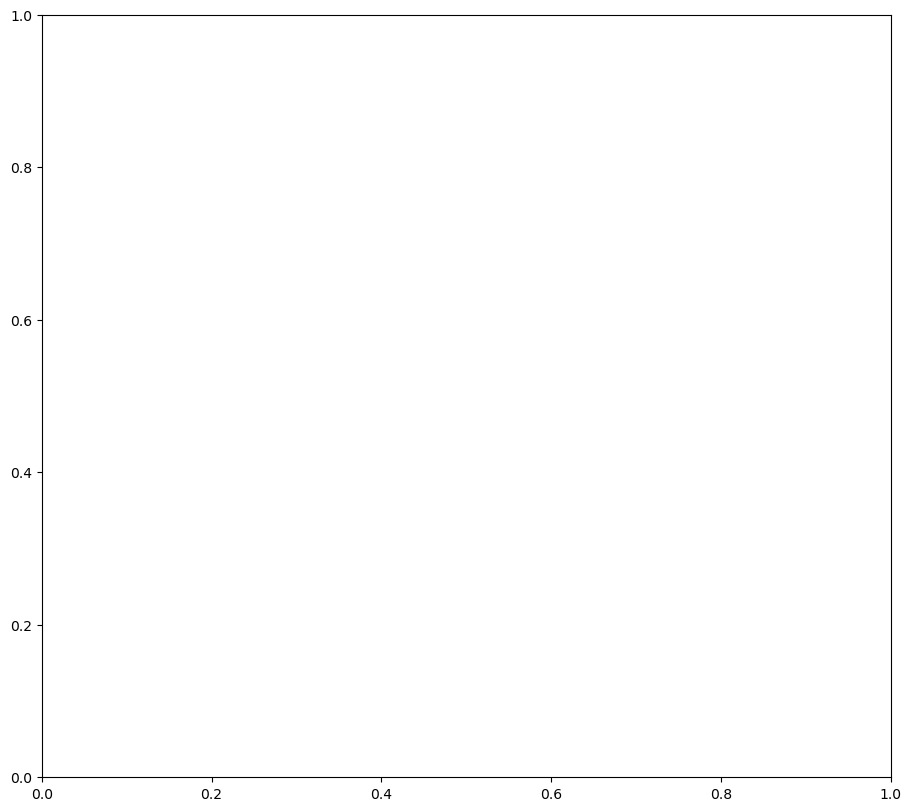

In [19]:
fig, ax= plt.subplots(1,1,figsize=(9,8), layout = 'constrained')
ax.plot(noise_level[:10].detach().cpu(), noisy_psnr_list[:10], label = 'PSNR of noisy images')
ax.plot(noise_level[:10].detach().cpu(), denoised_psnr_list[:10], label = 'PSNR of denoised images')
ax.plot(noise_level[:10].detach().cpu(), denoised_tweedies_psnr_list[:10], label = "PSNR of denoised images by Tweedie's")
ax.legend()
fig.supylabel('PSNR')
fig.supxlabel('Noise level (standard deviation of the noise)')
ax.title.set_text('PSNR of the denoising processes')

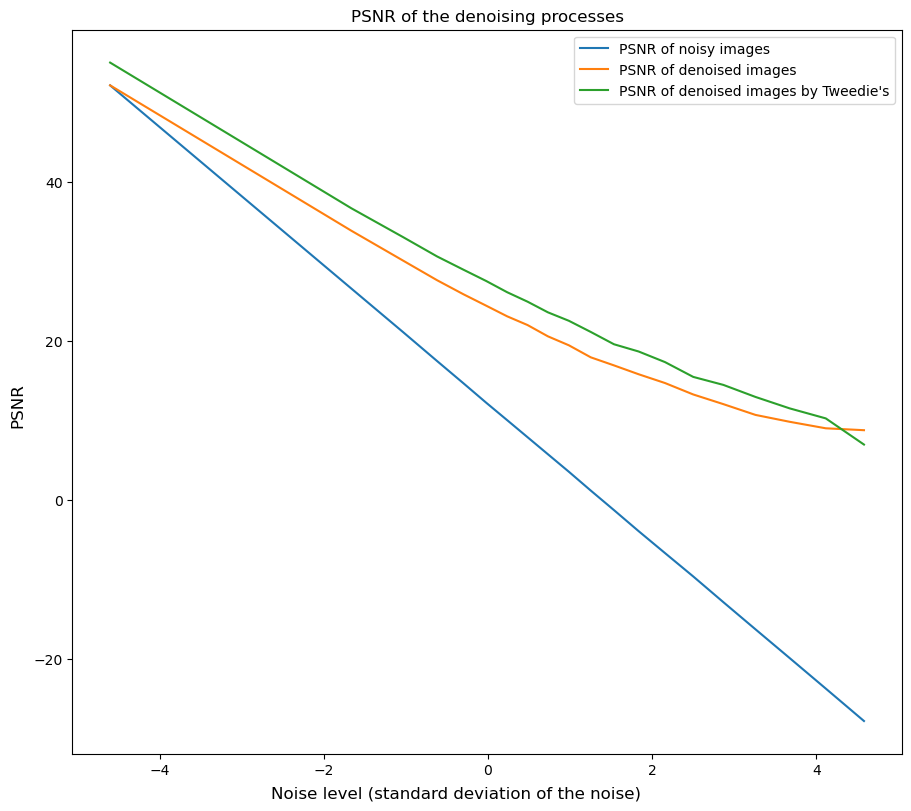

In [ ]:
fig, ax= plt.subplots(1,1,figsize=(9,8), layout = 'constrained')
ax.plot(torch.log(noise_level).detach().cpu(), noisy_psnr_list, label = 'PSNR of noisy images')
ax.plot(torch.log(noise_level).detach().cpu(), denoised_psnr_list, label = 'PSNR of denoised images')
ax.plot(torch.log(noise_level).detach().cpu(), denoised_tweedies_psnr_list, label = "PSNR of denoised images by Tweedie's")
ax.legend()
fig.supylabel('PSNR')
fig.supxlabel('Noise level (standard deviation of the noise)')
ax.title.set_text('PSNR of the denoising processes')

# WORK IN PROGRESS

## Multi-score methods

Source separations methods here take two models as inputs.

In [ ]:
observation = testbatch1[0]+testbatch2[0]
observation = observation.unsqueeze(0)

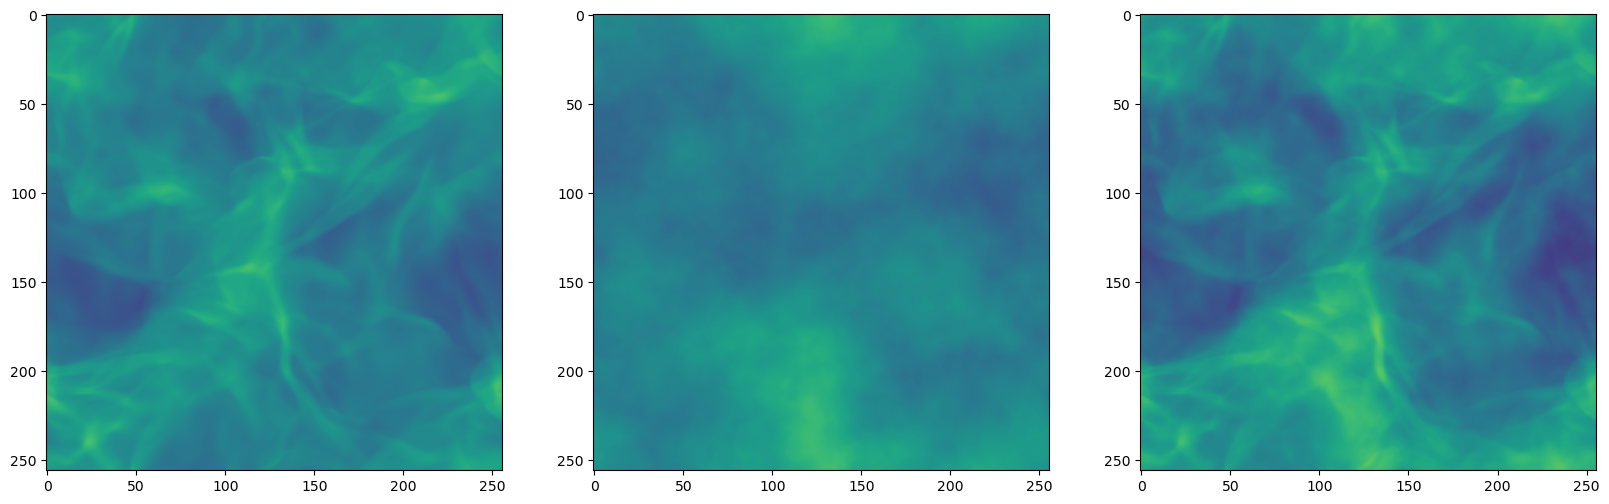

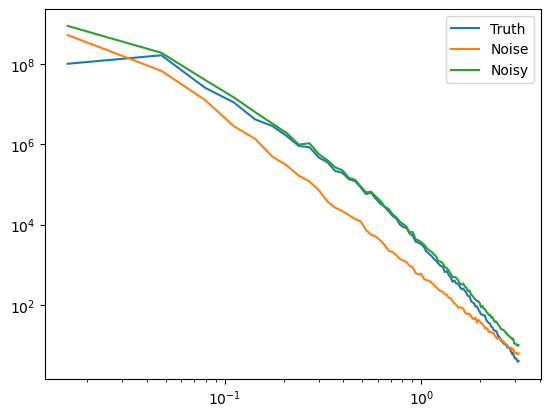

In [ ]:
fig, ax= plt.subplots(1,3,figsize=(20,8))
ax[0].imshow(testbatch1[0][0],vmin=amin, vmax=amax)
ax[1].imshow(testbatch2[0][0],vmin=amin, vmax=amax)
ax[2].imshow(observation[0][0],vmin=amin, vmax=amax)
plt.show()
_, b1, _ = power_spectrum_iso(testbatch1[0][0],bins=bins)
_, b2, _ = power_spectrum_iso(testbatch2[0][0],bins=bins)
_, b3, _ = power_spectrum_iso(observation[0][0].cpu(),bins=bins)
plot_ps(bins, [b1, b2, b3], ['Truth', 'Noise', 'Noisy'], show = True)

In [ ]:
sample, observation = method1_algo2(model1, model2, observation, NUM_SAMPLES=16)

100%|██████████| 2000/2000 [01:16<00:00, 26.27it/s]


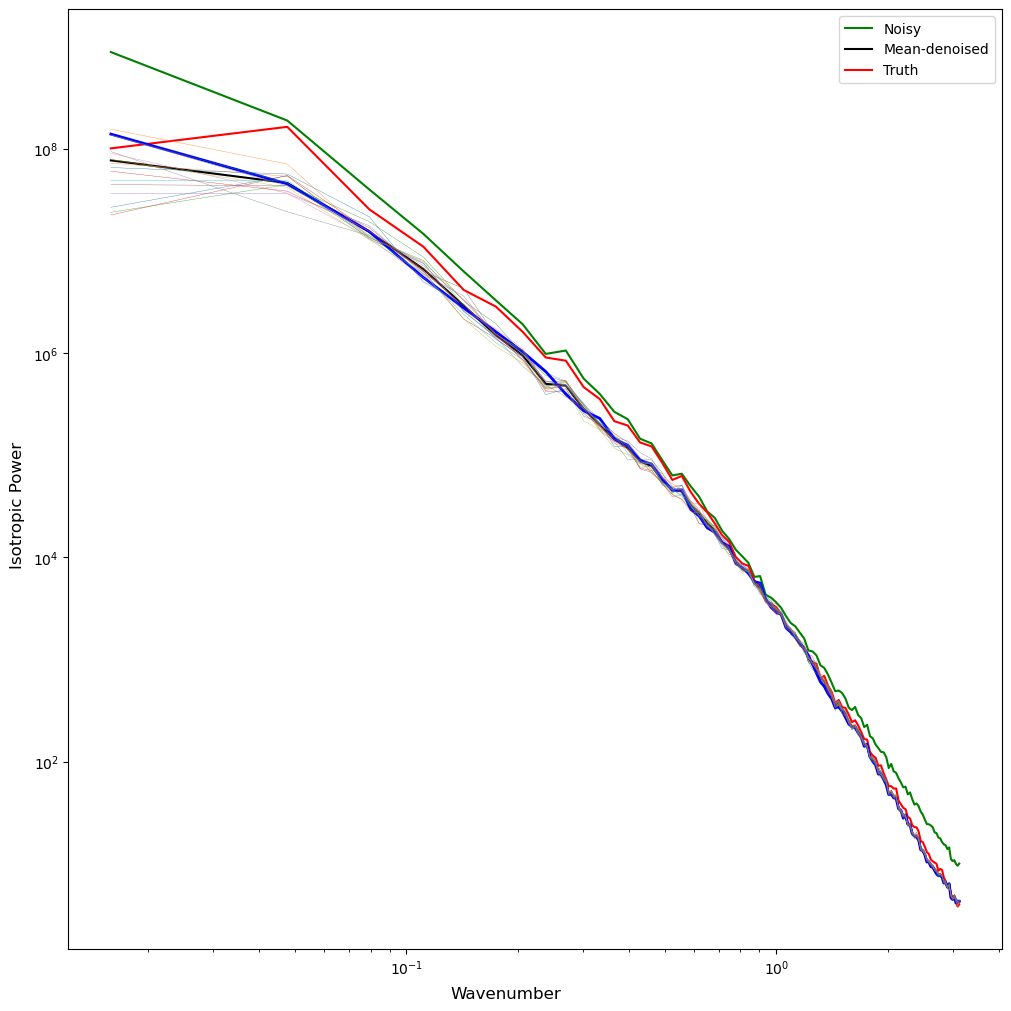

In [ ]:
b0, b3, mean_, std_, bins = compare_separation_power_spectrum_iso(testbatch1[0].unsqueeze(0),sample, noisy = observation, only_trajectories= True)

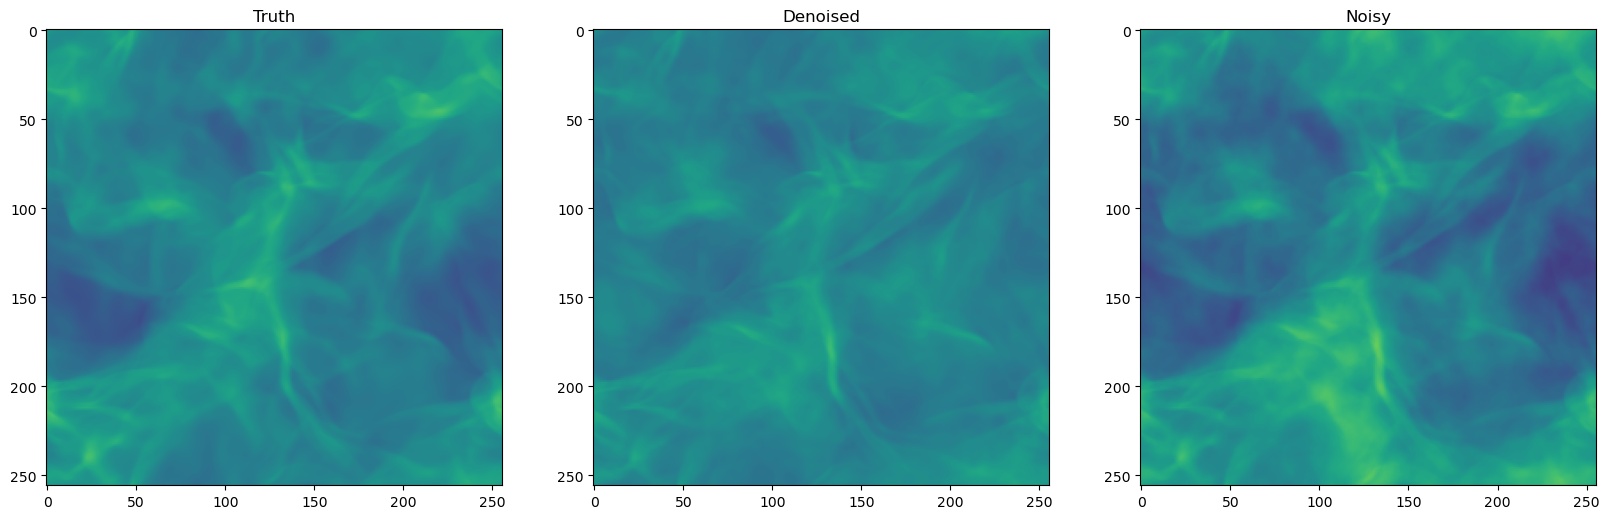

In [ ]:
fig, ax= plt.subplots(1,3,figsize=(20,8))
ax[0].imshow(testbatch1[0][0],vmin=amin, vmax=amax)
ax[0].title.set_text('Truth')
ax[1].imshow(sample[0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[1].title.set_text('Denoised')
ax[2].imshow(observation[0][0],vmin=amin, vmax=amax)
ax[2].title.set_text('Noisy')
